In [581]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pdpbox import pdp
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix

## Introduction

The goal of this study is to show how to quickly predict accurately and draw meaningul insights about the revenue range of a person. With no preliminary experience about this type of features we propose to do a quick feature engineering based out of the intuitive interpretation of the availale information. To allow us to draw insights we chose models which are easily interpretable while still offering good performances. To make sure to reflect the real performance of this method we take care of using cross-validation. And finally we show how to interpret the results and the insights generated by these models.

### 1. Results

We reach an accuracy of 95% with 2 models. The accuracy is close to 100% for the over-represented class (revenue <500000) and close to 40% for the under-represented one. A quick look at the feature importance shows than in both models, the financial attributes and the degree of education are in average strong predictors. However the relationship between these predictors and the target variable is not linear, meaning that depending on the value of other variable the correlation might be completely different.

### 2. Summary method
* Pre-cleaning: standardize na markers
* EDA
  * identify missing data fields
  * identify skewed data (models need normality assumption)
* Feature engineering
  * Extract extra information from umbrella fields
  * Add information by cross-correlating features
  * Cast nominal feature with hidden ordinality into numericals
* Nas
  * impute based on other relevant features
* Training set
  * Stratified cross validation to deal with unbalanced target
* Pre-processing
  * Boxcox for skewed data
  * One hot encoding for categoricals
  * Standardization for numerical features
* Training
  * Accuracy as metric
  * Algos:
    * Benchmark: dummy stratified
    * Interpretable models: logit and RDF
    * Vanilla algorithms
* Interpration
  * Confusion matrix
  * Feature importance

### 3.Improvements
* Model hyper parameter tuning (regularization)
* Model metric to balance missclassfications
* Correlate missclassification with predictors (cf residuals analysis)
* Refine feature eng/cleaning assumptions
* Add non linearity in logit: polynomial, feature combination

## Analysis
### 0. Pre-Cleaning
* #### Import

In [582]:
col_names =['age',
'class_of_worker','detailed_industry_recode','detailed_occupation_recode','education',
'wage_per_hour','enroll_in_edu_inst_last_wk','marital_stat','major_industry_code','major_occupation_code','race',
'hispanic_origin','sex',
'member_of_a_labor_union','reason_for_unemployment','full_or_part_time_employment_stat','capital_gains','capital_losses','dividends_from_stocks','tax_filer_stat','region_of_previous_residence','state_of_previous_residence','detailed_household_and_family_stat','detailed_household_summary_in_household','instance_weight','migration_code-change_in_msa','migration_code-change_in_reg','migration_code-move_within_reg','live_in_this_house_1_year_ago','migration_prev_res_in_sunbelt','num_persons_worked_for_employer','family_members_under_18','country_of_birth_father','country_of_birth_mother','country_of_birth_self','citizenship',
'own_business_or_self_employed','fill_inc_questionnaire_for_veteran_s_admin','veterans_benefits','weeks_worked_in_year','year','target']
dt = pd.read_csv('/Users/louis/Downloads/us_census_full/census_income_learn.csv',names = col_names)

In [583]:
dt.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,199523,NaN,NaN,NaN,34.4942,22.3109,0,15,33,50,90
class_of_worker,199523,9,Not in universe,100245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
detailed_industry_recode,199523,NaN,NaN,NaN,15.3523,18.0671,0,0,0,33,51
detailed_occupation_recode,199523,NaN,NaN,NaN,11.3066,14.4542,0,0,0,26,46
education,199523,17,High school graduate,48407,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wage_per_hour,199523,NaN,NaN,NaN,55.4269,274.896,0,0,0,0,9999
enroll_in_edu_inst_last_wk,199523,3,Not in universe,186943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital_stat,199523,7,Never married,86485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
major_industry_code,199523,24,Not in universe or children,100684,NaN,NaN,NaN,NaN,NaN,NaN,NaN
major_occupation_code,199523,15,Not in universe,100684,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* #### Nas
Look for NA markers and fill them with proper marker

In [584]:
for col in dt.select_dtypes(np.object).columns:
    print(col,dt[col].unique())

class_of_worker [' Not in universe' ' Self-employed-not incorporated' ' Private'
 ' Local government' ' Federal government' ' Self-employed-incorporated'
 ' State government' ' Never worked' ' Without pay']
education [' High school graduate' ' Some college but no degree' ' 10th grade'
 ' Children' ' Bachelors degree(BA AB BS)'
 ' Masters degree(MA MS MEng MEd MSW MBA)' ' Less than 1st grade'
 ' Associates degree-academic program' ' 7th and 8th grade'
 ' 12th grade no diploma' ' Associates degree-occup /vocational'
 ' Prof school degree (MD DDS DVM LLB JD)' ' 5th or 6th grade'
 ' 11th grade' ' Doctorate degree(PhD EdD)' ' 9th grade'
 ' 1st 2nd 3rd or 4th grade']
enroll_in_edu_inst_last_wk [' Not in universe' ' High school' ' College or university']
marital_stat [' Widowed' ' Divorced' ' Never married'
 ' Married-civilian spouse present' ' Separated' ' Married-spouse absent'
 ' Married-A F spouse present']
major_industry_code [' Not in universe or children' ' Construction' ' Entertainmen

In [585]:
na_cols = ['state_of_previous_residence','hispanic_origin','country_of_birth_self','country_of_birth_mother','country_of_birth_father','migration_prev_res_in_sunbelt','migration_code-move_within_reg','migration_code-change_in_reg','migration_code-change_in_msa']
dt[na_cols] = np.where((dt[na_cols]==' ?')|(dt[na_cols]==' NA'),pd.NA,dt[na_cols]) 

### 1. EDA
*  #### Target var

In [586]:
# formating
# Encode target as is below 50000 ?
dt.target = dt.target == ' - 50000.'

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


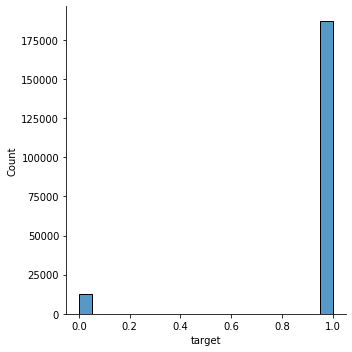

In [587]:
# plot dist
sns.displot(dt.target)

> unbalanced set, will have to stratify train/test splitting

*  #### Financial attributes

/Users/louis/.pyenv/versions/3.6.10/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


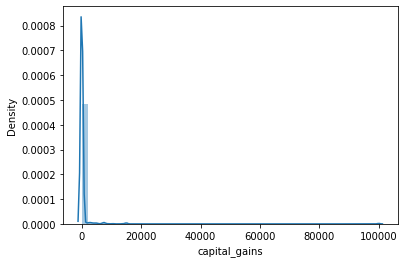

In [588]:
sns.distplot(dt['capital_gains'])

/Users/louis/.pyenv/versions/3.6.10/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


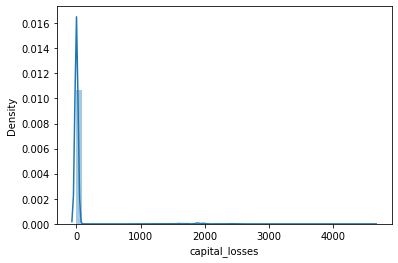

In [589]:
sns.distplot(dt['capital_losses'])

/Users/louis/.pyenv/versions/3.6.10/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


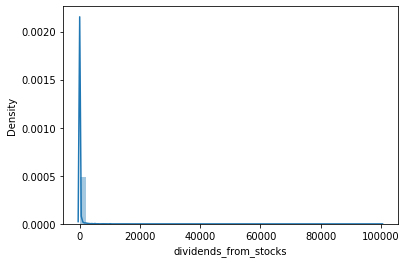

In [590]:
sns.distplot(dt['dividends_from_stocks'])

/Users/louis/.pyenv/versions/3.6.10/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


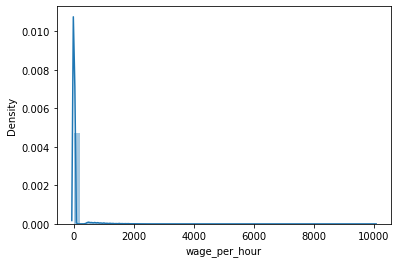

In [591]:
sns.distplot(dt['wage_per_hour'])


> All financial attributes are skewed, will have to transform them (boxcox)

*  ### Nas

In [592]:
nas = dt.isna().sum()/dt.shape[0]
nas[nas>0]

hispanic_origin                   0.004380
state_of_previous_residence       0.003548
migration_code-change_in_msa      0.499672
migration_code-change_in_reg      0.499672
migration_code-move_within_reg    0.499672
migration_prev_res_in_sunbelt     0.499672
country_of_birth_father           0.033645
country_of_birth_mother           0.030668
country_of_birth_self             0.017006
dtype: float64

> * the migration attribute have almost 50% of Nas. As we want to avoid to delete half of the dataset to train, we will fill those value marker for Nas
> * We will do the same for the country of birth attributes
> * we will fill the hispanic attribute with the most popular value given the country of birth
> * state_of_previous_residence: same as hispanic using region of previous residence

### 2. Feat eng
* #### Regexp

##### a.detailed_household_and_family_stat
Extract details about the household status. Fill family attributes with main status except for the age where we can infer that people without that attriubtes are adults.

In [593]:
# Extract sub attributes
pat = re.compile('^(?P<family_status>([a-zA-Z]+\s?)+)(?P<family_age>[<|>]?\d+\+?)?(?P<ever_married>.*marr)?((?P<sibling_status>.*)(?P<family_base>.*subfamily.*))?')
dt = dt.join(dt['detailed_household_and_family_stat'].str.strip().str.lower().str.extract(pat).drop(columns=[1,4]))
# Clean and fill nas
for col in ['ever_married','sibling_status','family_base']:
    dt[col] = np.where(dt[col].isna(),dt.family_status,dt[col])
dt.family_age = dt.family_age.fillna(value = '18+')

##### b. migration_code-change_in_msa
Extract info about migration direction.
Fill na with specific marker of lack of data rather than dele na because it represents half of the samples and that might be a clue about the person situation.

In [594]:
# Extract sub attributes
pat=re.compile('^((?P<migration_from>\w+)+ to (?P<migration_to>\w+))|(?P<migration_from_alt>\w+\s?)')
dt = dt.join(dt['migration_code-change_in_msa'].str.lower().str.strip().str.extract(pat).drop(columns=[0]))
# Clean and fill nas
for col in ['migration_from','migration_to']:
    dt[col] = np.where(dt[col].isna(),dt.migration_from_alt,dt[col])
    dt[col] = dt[col].fillna('not_available')
dt.drop(columns = ['migration_from_alt','migration_code-change_in_msa'],inplace = True)

##### c.migration_code-change_in_reg
Same as in msa

In [595]:
dt.columns

Index(['age', 'class_of_worker', 'detailed_industry_recode',
       'detailed_occupation_recode', 'education', 'wage_per_hour',
       'enroll_in_edu_inst_last_wk', 'marital_stat', 'major_industry_code',
       'major_occupation_code', 'race', 'hispanic_origin', 'sex',
       'member_of_a_labor_union', 'reason_for_unemployment',
       'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses',
       'dividends_from_stocks', 'tax_filer_stat',
       'region_of_previous_residence', 'state_of_previous_residence',
       'detailed_household_and_family_stat',
       'detailed_household_summary_in_household', 'instance_weight',
       'migration_code-change_in_reg', 'migration_code-move_within_reg',
       'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt',
       'num_persons_worked_for_employer', 'family_members_under_18',
       'country_of_birth_father', 'country_of_birth_mother',
       'country_of_birth_self', 'citizenship', 'own_business_or_self_employed',


In [596]:
dt['migration_code-move_within_reg'].unique()

array([<NA>, ' Same county', ' Nonmover', ' Different state in South',
       ' Different county same state', ' Not in universe',
       ' Different state in Northeast', ' Abroad',
       ' Different state in Midwest', ' Different state in West'],
      dtype=object)

In [597]:
# Extract sub attributes
pat = re.compile('^(different (?P<main_migration_reg>(\w+\s?))+)( same (?P<detail_migration_reg>\w+\s?)+)?|(?P<other>(\w+\s?)+)')
dt=dt.join(dt['migration_code-change_in_reg'].str.lower().str.strip().str.extract(pat).drop(columns = [0,2,3,6]))
# Clean and fill nas
for col in ['main_migration_reg','detail_migration_reg']:
    dt[col] = np.where(dt[col].isna(),dt.other,dt[col])
    dt[col] = dt[col].fillna('not_available')
dt.drop(columns = ['other','migration_code-change_in_reg'],inplace = True)

##### d.migration_code-move_within_reg
Same is in msa

In [598]:
# Extract sub attributes
pat = re.compile('^(?P<reg_different>different ((?!same)\w+\s?)+)?(same (?P<reg_same>\w+\s?)+)?|(?P<reg_other>(\w+\s?)+)')
dt = dt.join(dt['migration_code-move_within_reg'].str.lower().str.strip().str.extract(pat).drop(columns = [1,2,5]))
# Clean and fill nas
for col in ['reg_different','reg_same']:
    dt[col] = np.where(dt[col].isna(),dt.reg_other,dt[col])
    dt[col] = dt[col].fillna('not_available')
dt.drop(columns = ['reg_other','migration_code-move_within_reg'],inplace = True)

##### e.citizenship
Extract info about citizenship

In [599]:
# Extract sub attributes
pat = re.compile('^(?P<main_citizenship>(\w+\s?)+)-(?P<detail_citizenship> (\s?\w+\s?)+)')
dt = dt.join(dt['citizenship'].str.lower().str.strip().str.extract(pat).drop(columns = [1,3]))

##### f.education
Extract ordinal, see dict for order

In [600]:
# Build map
edu_map = {'High school graduate':13,
'Some college but no degree':14,
'10th grade':10,
'Children':0,
'Bachelors degree(BA AB BS)':15,
'Masters degree(MA MS MEng MEd MSW MBA)':16,
'Less than 1st grade':1,
'Associates degree-academic program':18,
'7th and 8th grade':8,
'12th grade no diploma':12,
'Associates degree-occup /vocational':18,
'Prof school degree (MD DDS DVM LLB JD)':19,
'5th or 6th grade':6,
'11th grade':11,
'Doctorate degree(PhD EdD)':17,
'9th grade':9,
'1st 2nd 3rd or 4th grade':4}
# Map attribute
dt['education_ordered'] = dt.education.str.strip().map(edu_map)

##### g.marital_stat
Extract details

In [601]:
# Extract sub attributes
pat = re.compile('^((?P<marital_main>married)-(?P<marital_sec>.*)?spouse (?P<marital_spouse>.*))|(?P<marital_other>(\w+\s?)+)')
dt = dt.join(dt['marital_stat'].str.lower().str.strip().str.extract(pat).drop(columns = [0,5]))
# Clean and fill na sub attributes
for col in ['marital_main','marital_sec','marital_spouse']:
    dt[col] = np.where(dt[col].isna(),dt.marital_other,dt[col])
    dt[col] = dt[col].fillna('not_available')
dt.drop(columns = ['marital_other'],inplace = True)

##### h.country_of_birth_self
fill na

In [602]:
# Fill na
dt.country_of_birth_self.fillna('not_informed',inplace = True)

##### i.country_of_birth_father
Compare to country_of_birth_mother and country_of_birth_self + fill nas

In [603]:
# FIll na
dt[['country_of_birth_mother','country_of_birth_father']]=dt[['country_of_birth_mother','country_of_birth_father']].fillna('not_available')
# Feature
dt['is_parents_from_same_country'] = dt.country_of_birth_father==dt.country_of_birth_father
dt['is_parents_from_same_country'] = np.where(dt.country_of_birth_father =='not_informed','not_informed', dt['is_parents_from_same_country'])

* #### Cleaning

##### a.hispanic_origin
clean na: feel with most common hispanic_origin for same country_of_birth_{self,mother,father}. Drop remaining nas

In [604]:
# # CLean NA markers
# dt.hispanic_origin = np.where(dt.hispanic_origin == ' NA',pd.NA,dt.hispanic_origin)
# DIstribution hispanic origin
hispanic_map = dt.dropna(subset = ['hispanic_origin']).groupby(['country_of_birth_self','country_of_birth_mother','country_of_birth_father','hispanic_origin'])['instance_weight'].sum().to_frame('total').sort_values('total',ascending=False).groupby(level = [0,1,2]).head(1).reset_index(level = 3).drop(columns=['total']).to_dict(orient='index')
# FIll na
def fill_na_(x):
    x.hispanic_origin = x.hispanic_origin if type(x.hispanic_origin)!=type(a)==pd._libs.missing.NAType else hispanic_map.get((x.country_of_birth_self,x.country_of_birth_mother,x.country_of_birth_father),{'hispanic_origin':pd.NA}).get('hispanic_origin')
    return x
dt = dt.apply(lambda x: fill_na_(x),axis = 1)#.dropna(subset='hispanic_origin')
# Drop remaining nas (2)
dt.dropna(subset= ['hispanic_origin'],inplace = True)

##### b.state_of_previous_residence

In [605]:
# Distribution state of previous residence
region_map = dt.dropna(subset=['state_of_previous_residence']).groupby(['region_of_previous_residence','state_of_previous_residence'])['instance_weight'].sum().to_frame('total').sort_values('total',ascending = False).groupby(level = 0).head(1).drop(columns = ['total']).reset_index(level = 1).to_dict(orient = 'index')
# fill na
def fill_na_(x):
    x.state_of_previous_residence = x.state_of_previous_residence if type(x.state_of_previous_residence)!=type(a)==pd._libs.missing.NAType else region_map.get(x.region_of_previous_residence,{'state_of_previous_residence':pd.NA}).get('state_of_previous_residence')
    return x
dt = dt.apply(lambda x: fill_na_(x),axis = 1)

##### c.migration_prev_res_in_sunbelt
FIll na same as msa

In [606]:
# FIllna
dt.migration_prev_res_in_sunbelt.fillna('not_available',inplace=True)

##### d.numerical at 99999
* add indicator of ceiling value 99999
* prepare for standardized boxcox transf (+1)
* include: 'capital_gains', 'capital_losses','dividends_from_stocks','num_persons_worked_for_employer','wage_per_hour'

In [607]:
# boxcox +1
dt[['capital_gains', 'capital_losses','dividends_from_stocks','wage_per_hour']]= dt[['capital_gains', 'capital_losses','dividends_from_stocks','wage_per_hour']]+1
# Ceiling indicator
for col in ['capital_gains', 'capital_losses','dividends_from_stocks']:
    dt['is_ceiling_'+col] = dt[col]==100000
dt['is_ceiling_wage_per_hour'] = dt['wage_per_hour']==10000

##### e.categorical
* include: 'detailed_industry_recode', 'detailed_occupation_recode','own_business_or_self_employed', 'veterans_benefits','year'
* change target
* clean whitespace

In [608]:
# Cast type
dt[['detailed_industry_recode', 'detailed_occupation_recode','own_business_or_self_employed', 'veterans_benefits','year']]=dt[['detailed_industry_recode', 'detailed_occupation_recode','own_business_or_self_employed', 'veterans_benefits','year']].astype(np.object)

In [609]:
cat_cols = dt.select_dtypes(np.object).columns
for col in cat_cols:
    try:
        dt[col]=dt[col].str.lower().str.strip()
        # split and add _
    except:
        pass

##### f.Bool
Cast to object

In [610]:
bool_cols = ['is_ceiling_capital_gains','is_ceiling_capital_losses','is_ceiling_dividends_from_stocks','is_ceiling_wage_per_hour']
dt[bool_cols] = dt[bool_cols].astype(np.object)

### 3. Model
* #### Dataset

##### a.train/test
* Deal with unbalance output class: Stratified split
* ratio: .9/.1

In [611]:
train,test=train_test_split(dt,train_size = .9,stratify = dt.target)

In [612]:
x_train,y_train = train.drop(columns = ['instance_weight','target']),train.target
x_test,y_test = test.drop(columns = ['instance_weight','target']),test.target

##### b.preprocess pipeline
The preprocess achieves the following operations:
* one hot encoding for categorical features
* box cox to deskew the financial attributes
* standardization for the numerical features left

In [613]:
cat_cols = x_train.select_dtypes(np.object).columns
boxcox_cols = ['wage_per_hour', 'capital_gains', 'capital_losses',
       'dividends_from_stocks']
stan_cols = ['age','num_persons_worked_for_employer',
       'weeks_worked_in_year', 'education_ordered']
pre_process = ColumnTransformer(transformers = [('one_hot_encode',OneHotEncoder(sparse=False),cat_cols),('boxcox',PowerTransformer(),boxcox_cols),('standardize',StandardScaler(),stan_cols)])

###### c.format feature names
The transformation created new features which we need to be able to track the name down

In [615]:
def remap(x):
    return prefix_map.get(x.split('_')[0])+f'_{"_".join(x.split("_")[1:])}'
def get_ohe_feat_names(pre_process):
    prefix_map = {f'x{c}':i for c,i in enumerate(pre_process.transformers_[0][2])}
    return pd.Series(pre_process.transformers_[0][1].get_feature_names()).map(lambda x: remap(x)).to_list()

In [616]:
def get_feature_names(pre_process):
    result =[]
    for step in pre_process.transformers_:
        if step[0]=='one_hot_encode':
            result += get_ohe_feat_names(pre_process)
        else:
            try:
                result += step[1].get_feature_names()
            except:
                result += step[2]
    return result

In [617]:
features = get_feature_names(pre_process)

* #### Training

##### a.Add models
We chose interpretable models  with different level of flexibility (logit and RF). We will use a dummy stratified model as a benchmark.

In [624]:
# Create estimators
dummy = DummyClassifier(strategy = 'stratified')
logit = LogisticRegression(max_iter = 1000)
rdf = RandomForestClassifier()
# Create pipelines
dummy_p = Pipeline(steps = [('preprocess',pre_process),('dummy',dummy)])
logit_p = Pipeline(steps = [('preprocess',pre_process),('logit',logit)])
rdf_p = Pipeline(steps = [('preprocess',pre_process),('rdf',rdf)])

##### b.Training
We choose the accuracy on the test set as the scoring metric assuming that there is not a class more valuable than the other

In [625]:
result = []
for pipe in [dummy_p,logit_p,rdf_p]:
    model_name = pipe.steps[1][0]
    pipe.fit(x_train,y_train)
    result += [(model_name,accuracy_score(y_test,pipe.predict(x_test)))]

training dummy
training logit
training rdf


* #### Evaluation

##### a.Accuracy

In [689]:
# print result
for a,b in result:
    print(f'Score model {a}: {b}')

ValueError: too many values to unpack (expected 2)

> * RDF and Logit show an improvement of more than 6% compared to the dummy model

##### b.Confusion matrix

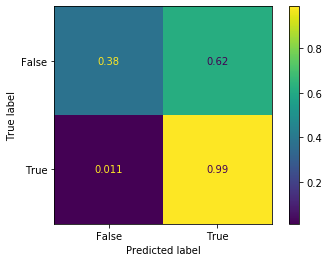

In [635]:
# logit
plot_confusion_matrix(logit_p,X = x_test,y_true = y_test,normalize = 'true')

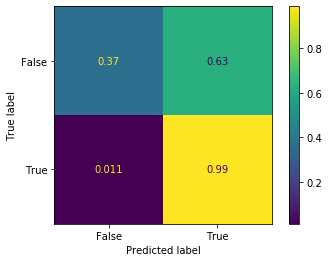

In [636]:
#rdf
plot_confusion_matrix(rdf_p,X = x_test,y_true = y_test,normalize = 'true')

* #### Strong predictors

Look for the strongest predictors
###### a.RDF
* general approach using CART algorithm

In [658]:
rdf_fi = pd.DataFrame(rdf_p.steps[1][1].feature_importances_,index = get_feature_names(pre_process),columns =['feature_importance'])

In [666]:
rdf_fi.sort_values('feature_importance',ascending = False).head(10)

,feature_importance
age,0.093260
dividends_from_stocks,0.070970
education_ordered,0.048341
num_persons_worked_for_employer,0.040738
weeks_worked_in_year,0.029159
capital_gains,0.019620
major_occupation_code_executive admin and managerial,0.017354
sex_female,0.015054
sex_male,0.014008
detailed_occupation_recode_2,0.013571


* Close approach on a single variable (here age) by controlling each feature and varying the studied feature while looking at the impact on the prediction

In [684]:
pdp_age = pdp.pdp_isolate(
    model=rdf_p.steps[1][1], dataset=pd.DataFrame(x_train_transf,columns = get_feature_names(pre_process)), model_features=get_feature_names(pre_process), feature='age'
)

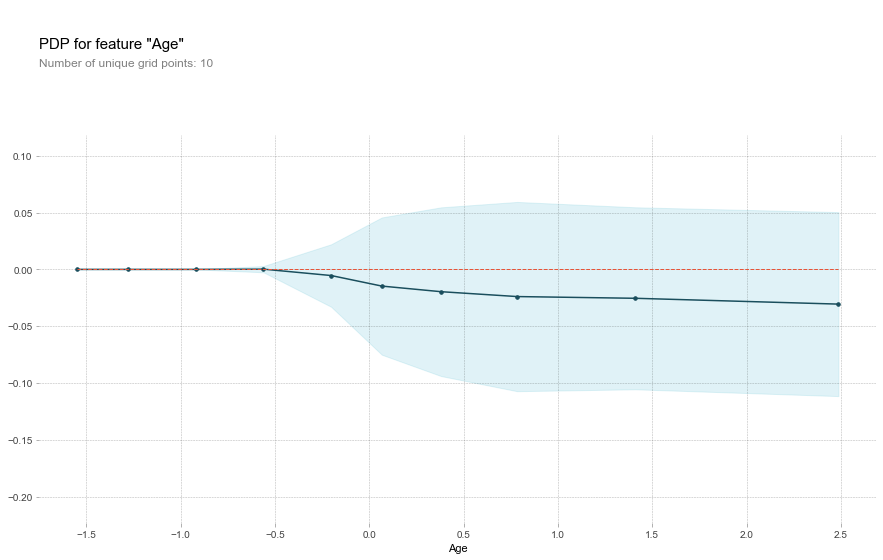

In [685]:
# default
fig, axes = pdp.pdp_plot(pdp_age, 'Age')

> * Overall Age seems to impact negatively the target output (ie to favor >50000 revenues)
> * However there is a wide interval of variation, which accounts for the different combination of volues of the controlled features (see detailed view below)


NB: the age here is standaradized

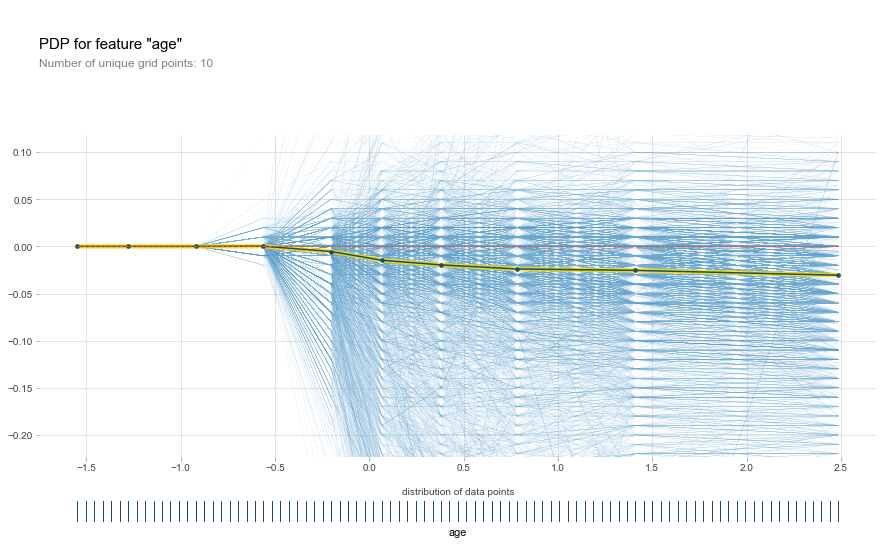

In [687]:
# more info
fig, axes = pdp.pdp_plot(pdp_age, 'age', plot_lines=True, frac_to_plot=0.05, plot_pts_dist=True)

###### b.Logit

In [672]:
logit_fi = pd.DataFrame(logit_p.steps[1][1].coef_.squeeze(),index = get_feature_names(pre_process),columns =['feature_importance'])
logit_fi['abs_feature_importance'] = np.abs(logit_fi.feature_importance)

In [673]:
logit_fi.sort_values('abs_feature_importance',ascending = False).head(10)

,feature_importance,abs_feature_importance
is_ceiling_dividends_from_stocks_False,2.109831,2.109831
is_ceiling_dividends_from_stocks_True,-1.998063,1.998063
country_of_birth_self_scotland,-1.401453,1.401453
tax_filer_stat_nonfiler,1.370817,1.370817
is_ceiling_capital_gains_False,1.337320,1.337320
education_doctorate degree(phd edd),-1.251871,1.251871
country_of_birth_father_el-salvador,1.233942,1.233942
is_ceiling_capital_gains_True,-1.225552,1.225552
detailed_industry_recode_20,-1.207741,1.207741
country_of_birth_mother_outlying-u s (guam usvi etc),1.164763,1.164763


> * Recognize similar predictor to the ones found by the RDF (dividends, education)
> * It seems to have overfit on certain categories (cf born in scotland, el salvador)

### 4.Improvements
* Model hyper parameter tuning (regularization)
* Model metric to balance missclassfications
* Correlate missclassification with predictors (cf residuals analysis)
* Refine feature eng/cleaning assumptions
* Add non linearity in logit: polynomial, feature combination